# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. Метрика - RMSE 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

RAND = 22

# Подготовка данных

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Для обучения модели нам понадобятся признаки 'VehicleType', 'Gearbox', 'RegistrationYear', 'Power', 'Kilometer', 'FuelType', 'NotRepaired', 'Price'
Так как в них присутствуют пропущенные значения, попытаемся заполнить их пользуясь брендом и моделью машины. Создадим новый признак Name

In [4]:
df['Name'] = df['Brand'] + ' ' + df['Model']

In [5]:
# заполняем пропуски в VehicleType
names_vt = [name for name in list(df[df['VehicleType'].isna()]['Name'].unique()) if isinstance(name, str) == True]

for name in names_vt:
    df.loc[(df['Name']==name)&(df['VehicleType'].isna()), 'VehicleType'] = df[df['Name']==name]['VehicleType'].value_counts().index[0]

In [6]:
df['VehicleType'].isna().sum()

6828

Несколько пропущенных значений остались, потому что у некоторых машин признак Name имеет значение NaN  
Таким же образом заполним пропуски в Gearbox

In [7]:
# заполняем пропуски в Gearbox
names_gb = [name for name in list(df[df['Gearbox'].isna()]['Name'].unique()) if isinstance(name, str) == True]

for name in names_gb:
    df.loc[(df['Name']==name)&(df['Gearbox'].isna()), 'Gearbox'] = df[df['Name']==name]['Gearbox'].value_counts().index[0]

In [8]:
df['Gearbox'].isna().sum()

4131

Большинство пропущенных значений заполнены)  
Остался признак FuelType

In [9]:
# заполняем пропуски в FuelType
names_ft = [name for name in list(df[df['FuelType'].isna()]['Name'].unique()) if isinstance(name, str) == True]

for name in names_gb:
    df.loc[(df['Name']==name)&(df['FuelType'].isna()), 'FuelType'] = df[df['Name']==name]['FuelType'].value_counts().index[0]

In [10]:
df['FuelType'].isna().sum()

7184

Удалим оставшиеся пропущенные значения в интересующих нас признаков

In [11]:
df = df.dropna(subset=['VehicleType', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 'NotRepaired', 'Price'], axis=0).reset_index(drop=True)

Также посмотрим на дубликаты

In [12]:
df.duplicated().sum()

4

In [13]:
df = df.drop_duplicates().reset_index(drop=True)

Подготовим данные для модели

In [14]:
data_for_model = df[['VehicleType', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 'NotRepaired', 'Price', 'RegistrationYear']]
data_for_model.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,NotRepaired,Price,RegistrationYear
0,coupe,manual,190,125000,gasoline,yes,18300,2011
1,small,manual,75,150000,petrol,no,1500,2001
2,small,manual,69,90000,gasoline,no,3600,2008
3,sedan,manual,102,150000,petrol,yes,650,1995
4,convertible,manual,109,150000,petrol,no,2200,2004


Проведем предобработку, чтобы в модель попали чистые данные

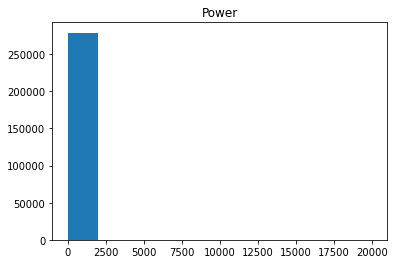

In [15]:
plt.hist(data_for_model['Power'])
plt.title('Power')
plt.show()

In [16]:
data_for_model['Power'].min(), data_for_model['Power'].max()

(0, 20000)

Присутствуют выбросы и нулевые значения в столбце Power. Избавимся от них с помощью процентилей

In [17]:
max_threshold = data_for_model['Power'].quantile(0.99)
min_threshold = data_for_model['Power'].quantile(0.1)
print(min_threshold, max_threshold)

54.0 306.0


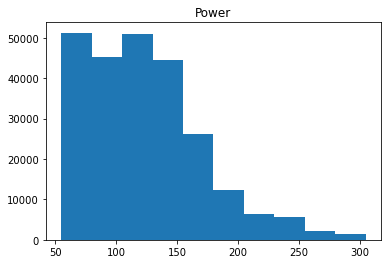

In [18]:
data_for_model = data_for_model[(data_for_model['Power'] < max_threshold) & (data_for_model['Power'] > min_threshold)]

plt.hist(data_for_model['Power'])
plt.title('Power')
plt.show()

Теперь распределение выглядит лучше)

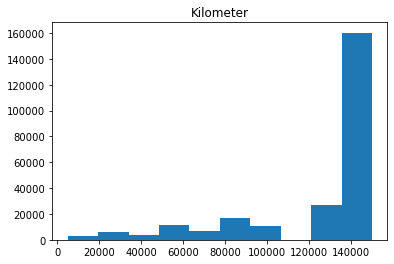

In [19]:
plt.hist(data_for_model['Kilometer'])
plt.title('Kilometer')
plt.show()

Большинство значений в столбце Kilometer находится районе 15000. Нулевых значений нет

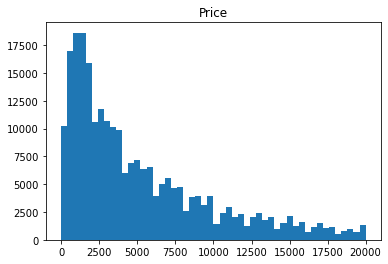

In [20]:
plt.hist(data_for_model['Price'], bins=50)
plt.title('Price')
plt.show()

Присутствуют много нулевых значений в столбце Price

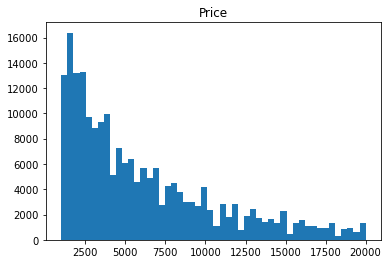

In [21]:
data_for_model = data_for_model[data_for_model['Price'] > 1000]

plt.hist(data_for_model['Price'], bins=50)
plt.title('Price')
plt.show()

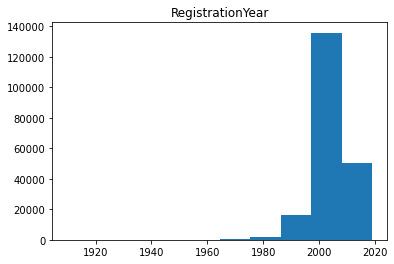

In [22]:
plt.hist(data_for_model['RegistrationYear'])
plt.title('RegistrationYear')
plt.show()

Есть сильные выбросы в годе регистрации автомобиля. Так же избавимся от них с помощью процентилей

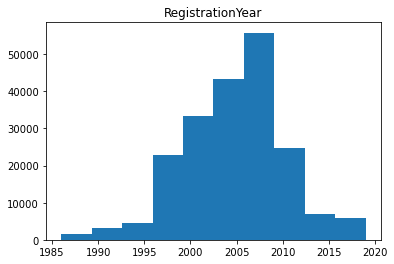

In [23]:
min_threshold = data_for_model['RegistrationYear'].quantile(0.01) # 1985
data_for_model = data_for_model[data_for_model['RegistrationYear'] > min_threshold]

plt.hist(data_for_model['RegistrationYear'])
plt.title('RegistrationYear')
plt.show()

# Моделирование

Разделим данные на матрицу признаков и вектор ответов

In [24]:
X = data_for_model.drop('Price', axis=1)
y = data_for_model['Price']

Преобразуем категориальные признаки в численный, пользуясь техникой OneHotEncoding

In [25]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,Power,Kilometer,RegistrationYear,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,190,125000,2011,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
1,75,150000,2001,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,69,90000,2008,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
4,109,150000,2004,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,105,150000,2004,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


Разделим на обучающую и тестовую выборки

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RAND)

In [27]:
X_train.shape, X_test.shape

((141565, 18), (60671, 18))

Также масштабируем признаки, чтобы все имели равносильное влияние на работу модели

In [28]:
numeric = ['Power', 'Kilometer', 'RegistrationYear']
scaler = MinMaxScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [29]:
X_train.head()

,Power,Kilometer,RegistrationYear,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
15450,0.200,1.0,0.454545,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
122857,0.460,1.0,0.424242,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
263458,0.380,1.0,0.393939,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
12171,0.340,1.0,0.757576,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1
238360,0.548,1.0,0.606061,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


In [30]:
# функция для расчета rmse

def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

In [31]:
rmse_score = make_scorer(rmse, greater_is_better = False)

Проверим значение метрики на константной модели, которая каждый раз предсказывает среднее значение 

In [32]:
y_test_mean = pd.Series(y_test.mean(), index=y_test.index)
rmse(y_test_mean, y_test)

4587.710337917496

## Baseline

### Linear Regression

In [33]:
model = LinearRegression()

In [34]:
%%time

model.fit(X_train, y_train)

Wall time: 257 ms


LinearRegression()

In [35]:
%%time

y_pred = model.predict(X_test)

Wall time: 22 ms


In [36]:
rmse(y_pred, y_test)

2783.88695005378

### Random Forest Regressor

In [37]:
model = RandomForestRegressor(random_state=RAND)

In [38]:
%%time

model.fit(X_train, y_train)

Wall time: 57.9 s


RandomForestRegressor(random_state=22)

In [39]:
%%time

y_pred = model.predict(X_test)

Wall time: 3.23 s


In [40]:
rmse(y_pred, y_test)

1845.1198449909043

### LightGBM

In [41]:
model = LGBMRegressor()

In [42]:
%%time

model.fit(X_train, y_train)

Wall time: 996 ms


LGBMRegressor()

In [43]:
%%time

y_pred = model.predict(X_test)

Wall time: 337 ms


In [44]:
rmse(y_pred, y_test)

1924.744901193449

Дольше всех обучается алгоритм случайного леса. Худший показатель метрики RMSE у линейной регрессии. Дальше будем работать с LightGBM, так как он быстро обучается и качество у него неплохое. Думаю, если подберем гиперпараметры качество еще улучшится

## Подбор гиперпараметров

In [45]:
parameters_grid = {
    'max_depth': [5, 7, 10],
    'num_leaves': [50, 80, 110],
    'n_estimators': [100, 300, 500]
}

model = LGBMRegressor()
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring=rmse_score, cv=cv, verbose=1000)

In [46]:
# grid_cv.fit(X_train, y_train)

In [47]:
# grid_cv.best_params_

# {'max_depth': 10, 'n_estimators': 500, 'num_leaves': 110}

In [48]:
parameters_grid = {
    'max_depth': [10, 15, 20],
    'num_leaves': [110, 130, 150],
    'n_estimators': [500, 700, 1000]
}

model = LGBMRegressor()
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring=rmse_score, cv=cv, verbose=1000)

In [49]:
# grid_cv.fit(X_train, y_train)

In [50]:
# grid_cv.best_params_

# {'max_depth': 20, 'n_estimators': 500, 'num_leaves': 130}

In [51]:
parameters_grid = {
    'max_depth': [20, 25, 30],
    'num_leaves': [120, 130, 140],
    'n_estimators': [400, 500, 600]
}

model = LGBMRegressor()
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring=rmse_score, cv=cv, verbose=1000)

In [52]:
# grid_cv.fit(X_train, y_train)

In [53]:
# grid_cv.best_params_

# {'max_depth': 20, 'n_estimators': 500, 'num_leaves': 130}

In [54]:
parameters_grid = {
    'max_depth': [18, 20, 22],
    'num_leaves': [128, 130, 132],
    'n_estimators': [480, 500, 520]
}

model = LGBMRegressor()
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring=rmse_score, cv=cv, verbose=1000)

In [55]:
# grid_cv.fit(X_train, y_train)

In [56]:
# grid_cv.best_params_

# {'max_depth': 18, 'n_estimators': 480, 'num_leaves': 130}

In [57]:
best_params = {'max_depth': 18, 'n_estimators': 480, 'num_leaves': 130}

In [58]:
model = LGBMRegressor(**best_params)

In [59]:
%%time

model.fit(X_train, y_train)

Wall time: 5.11 s


LGBMRegressor(max_depth=18, n_estimators=480, num_leaves=130)

In [60]:
%%time

y_pred = model.predict(X_test)

Wall time: 1.96 s


In [61]:
rmse(y_pred, y_test)

1785.9165188243405

Время обучения: 5 секунд  
Скорость предсказания: 2 секунды  
RMSE: 1786